# Modeling individual survival
Natalia Vélez, August 2020

The goal of this notebook is to create the inputs for the survival regression.

In [37]:
%matplotlib inline

import os,re,glob,datetime,json,scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import notebook

from networkx.drawing.nx_agraph import graphviz_layout

sns.set_style('white')
sns.set_context('talk')

## Find families & players included in analysis

Find start of new-style map logs:

In [2]:
seed_file = '../3_technology/outputs/seed_changes.txt'
with open(seed_file, 'r') as seed_handle:
    seeds = seed_handle.read().splitlines()

seeds = [int(s) for s in seeds]
start_t = seeds[0]

print('First seed: %i' % start_t)
print(datetime.datetime.fromtimestamp(start_t))

First seed: 1573895673
2019-11-16 09:14:33


Families included in analysis:

In [3]:
success_df = pd.read_csv('../2_demographics/outputs/family_fitness.tsv', sep='\t')
success_df['fam_start'] = success_df['family'].str.extract('(?<=time-)([0-9]+)')
success_df['fam_start'] = success_df['fam_start'].astype(np.int)
success_df = success_df[success_df['fam_start'] >= start_t]

included_families = success_df['family'].values

print(success_df.shape)
success_df.head()

(4054, 11)


,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size,longest_path,fam_start
92,time-1573895755_eve-2276905_name-ZABICKI,9,17,12,11,0.521739,0.010397,50.181818,8.869565,3,1573895755
93,time-1573895904_eve-2276911_name-ROHRER,1,3,4,5,0.444444,0.024691,18.000000,1.333333,2,1573895904
94,time-1573896101_eve-2276917_name-BADA,14,32,17,21,0.447368,0.006339,70.571429,14.315789,5,1573896101
95,time-1573896134_eve-2276919_name-SARINA,33,68,36,38,0.486486,0.003331,146.052632,33.081081,9,1573896134
96,time-1573896495_eve-2276927_name-LISSADE,311,454,314,146,0.682609,0.000470,1452.465753,309.904348,46,1573896495


Load each player's family:

In [4]:
family_df = pd.read_csv('../2_demographics/outputs/family_playerID.tsv', sep='\t', index_col=0)
family_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,avatar,family
0,3308592,time-1599460982_eve-3308568_name-SOL
1,3308568,time-1599460982_eve-3308568_name-SOL
2,3308504,time-1599458188_eve-3308504_name-SOL
3,3308439,time-1599456178_eve-3308427_name-MORALES
4,3308507,time-1599456178_eve-3308427_name-MORALES


Prepare lifelogs:

In [5]:
# Add family to lifelogs
all_life = pd.read_csv('../2_demographics/outputs/all_lifelogs_compact.tsv', sep='\t', index_col=0)
life_df = pd.merge(all_life, family_df, on='avatar')

# Include only avatars that:
# - belong to families within the time period studied
# - had died by the time data were accessed 
# - did not disconnect as infants (age > 2)
life_df = life_df[life_df['family'].isin(included_families)]
life_df = life_df[life_df['age'] > 2]
life_df = life_df.dropna(subset=['age'])

# Clean up
life_df = life_df.reset_index(drop=True)
life_df = life_df[['player', 'avatar', 'parent', 'family', 'tBirth', 'tDeath', 'age', 'cause_of_death']]
print(life_df.shape)
life_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(419656, 8)


,player,avatar,parent,family,tBirth,tDeath,age,cause_of_death
0,310d12780dbb316a3b50f83adbf9ce76973172bb,3308597,3308571,time-1599447278_eve-3308179_name-MATSU,1599462620,1.599464e+09,28.89,hunger
1,de586e48a15f97f09e71355fcc82cea88d29633a,3308595,3308576,time-1599411200_eve-3307135_name-SUN,1599462571,1.599465e+09,36.92,hunger
2,3da17539b16d6fe6911aefc57388bae9d1303e22,3308591,3308571,time-1599447278_eve-3308179_name-MATSU,1599462365,1.599465e+09,45.82,hunger
3,043719a2996d748e294d308706447d2e6ce30181,3308583,3308537,time-1599454213_eve-3308371_name-LUNA,1599462113,1.599463e+09,20.11,hunger
4,49bd234c63fac4073c98cc23dab916528f87e634,3308581,3308545,time-1599447278_eve-3308179_name-MATSU,1599461853,1.599465e+09,45.37,hunger


In [6]:
n_players = len(np.unique(life_df['player']))
n_families = len(np.unique(life_df['family']))
n_avatars = len(np.unique(life_df['avatar']))

print('N =\t%i players\n\t%i families\n\t%i avatars' % (n_players, n_families, n_avatars))

N =	23915 players
	4054 families
	419656 avatars


## Player & parent expertise

In [7]:
#expertise_df = pd.read_csv('../2_demographics/outputs/player_expertise.tsv', sep='\t')
expert_df = all_life.copy()
expert_df = expert_df[['player', 'avatar', 'tBirth', 'age']]
expert_df = expert_df.sort_values(['player', 'tBirth']).reset_index(drop=True)
expert_df['n_life'] = expert_df.groupby('player').cumcount()
expert_df['gametime'] = expert_df.groupby('player')['age'].cumsum()
expert_df['gametime'] = expert_df.groupby('player')['gametime'].shift(periods=1, fill_value=0)
expert_df.head()

,player,avatar,tBirth,age,n_life,gametime
0,00006debdd4d630a4a5aa395135a70a69e0db01e,630641,1552916631,13.88,0,0.00
1,00006debdd4d630a4a5aa395135a70a69e0db01e,630737,1552917470,4.98,1,13.88
2,00006debdd4d630a4a5aa395135a70a69e0db01e,630799,1552917791,4.68,2,18.86
3,0001394319e5e63bb74219fef647e9ff24507a21,214206,1550132363,33.78,0,0.00
4,0001394319e5e63bb74219fef647e9ff24507a21,214530,1550134720,7.25,1,33.78


Load expertise:

In [8]:
child_expertise = expert_df.copy()
child_expertise = child_expertise[['avatar', 'n_life', 'gametime']]
child_expertise.head()

,avatar,n_life,gametime
0,630641,0,0.00
1,630737,1,13.88
2,630799,2,18.86
3,214206,0,0.00
4,214530,1,33.78


Make a copy (to look up parent expertise):

In [9]:
parent_expertise = child_expertise.copy()
parent_expertise = parent_expertise.rename(columns={'avatar': 'parent', 'n_life': 'parent_life', 'gametime': 'parent_gametime'})
parent_expertise.head()

,parent,parent_life,parent_gametime
0,630641,0,0.00
1,630737,1,13.88
2,630799,2,18.86
3,214206,0,0.00
4,214530,1,33.78


Merge with lifelogs:

In [10]:
life_expertise = pd.merge(life_df, child_expertise, on='avatar', how='left')
life_expertise = pd.merge(life_expertise, parent_expertise, on='parent', how='left')
life_expertise.head()

,player,avatar,parent,family,tBirth,tDeath,age,cause_of_death,n_life,gametime,parent_life,parent_gametime
0,310d12780dbb316a3b50f83adbf9ce76973172bb,3308597,3308571,time-1599447278_eve-3308179_name-MATSU,1599462620,1.599464e+09,28.89,hunger,0,0.00,64.0,3179.97
1,de586e48a15f97f09e71355fcc82cea88d29633a,3308595,3308576,time-1599411200_eve-3307135_name-SUN,1599462571,1.599465e+09,36.92,hunger,34,887.18,980.0,43618.02
2,3da17539b16d6fe6911aefc57388bae9d1303e22,3308591,3308571,time-1599447278_eve-3308179_name-MATSU,1599462365,1.599465e+09,45.82,hunger,245,8579.85,64.0,3179.97
3,043719a2996d748e294d308706447d2e6ce30181,3308583,3308537,time-1599454213_eve-3308371_name-LUNA,1599462113,1.599463e+09,20.11,hunger,0,0.00,66.0,1898.64
4,49bd234c63fac4073c98cc23dab916528f87e634,3308581,3308545,time-1599447278_eve-3308179_name-MATSU,1599461853,1.599465e+09,45.37,hunger,930,36784.80,143.0,7574.32


Note: Some avatars are missing expertise info. This may be due to an error in logging or in downloading. These are a tiny, tiny fraction of the whole, so we will just drop them for now.

In [11]:
missing_gametime = ~np.isfinite(life_expertise['gametime'])
missing_parent = (life_expertise['parent_gametime'] > 0) & (~np.isfinite(life_expertise['parent_gametime']))

print('%i missing gametime data' % np.sum(missing_gametime))
print('%i non-Eves missing parent gametime' % np.sum(missing_parent))
print('Dropping %i entries for now' % np.sum(missing_gametime | missing_parent))

life_expertise = life_expertise[~missing_gametime & ~missing_parent]
print(life_expertise.shape)

96 missing gametime data
0 non-Eves missing parent gametime
Dropping 96 entries for now
(419560, 12)


## Cumulative viability

In [12]:
life_viability = life_expertise.copy()
life_viability = life_viability.sort_values(by=['family', 'tBirth'])
life_viability = life_viability.reset_index(drop=True)

life_viability['adult'] = (life_viability['age'] >= 14.0)*1
life_viability['adult_count'] = life_viability.groupby('family')['adult'].cumcount()
life_viability['adult_sum'] = life_viability.groupby('family')['adult'].cumsum()
life_viability['adult_sum'] = np.where(life_viability['adult'] == 1, 
                                       life_viability['adult_sum']-1,
                                       life_viability['adult_sum'])
life_viability.head()

,player,avatar,parent,family,tBirth,tDeath,age,cause_of_death,n_life,gametime,parent_life,parent_gametime,adult,adult_count,adult_sum
0,6290670c4fe41726873b54d070b869fdcc9e06e7,2276905,-1,time-1573895755_eve-2276905_name-ZABICKI,1573895755,1.573899e+09,60.00,oldAge,201,9736.39,NaN,NaN,1,0,0
1,d74e306b2dc466835e85acf5b53a4391e2346857,2276906,2276905,time-1573895755_eve-2276905_name-ZABICKI,1573895772,1.573896e+09,10.05,hunger,229,7267.02,201.0,9736.39,0,1,1
2,b0527ef2371111cb11369f4a5fe021c1bdb06ed9,2276909,2276905,time-1573895755_eve-2276905_name-ZABICKI,1573895873,1.573899e+09,45.99,murdered,416,15933.89,201.0,9736.39,1,2,1
3,e417361f8e2770a2a5647353af05f6e621be69c0,2276914,2276905,time-1573895755_eve-2276905_name-ZABICKI,1573895976,1.573898e+09,41.77,murdered,25,678.56,201.0,9736.39,1,3,2
4,0c7bc0236deae0bb888f63c4f4d94f4ab7cefad1,2276922,2276905,time-1573895755_eve-2276905_name-ZABICKI,1573896361,1.573897e+09,9.73,hunger,45,1931.45,201.0,9736.39,0,4,3


## Pick a subsample of families

In [51]:
10**q_x

array([   3.,   18.,  127., 2786.])

In [53]:
family_sizes = life_viability.groupby(['family'])['avatar'].agg('count').reset_index()
family_sizes = family_sizes.rename(columns={'avatar': 'size'})
family_sizes['log_size'] = np.log10(family_sizes['size'])
family_sizes['size_q'] = pd.qcut(family_sizes['log_size'], 4, labels=False)
family_sizes['q_label'] = pd.qcut(family_sizes['log_size'], 4)
family_sizes

,family,size,log_size,size_q,q_label
0,time-1573895755_eve-2276905_name-ZABICKI,16,1.204120,1,"(0.477, 1.255]"
1,time-1573895904_eve-2276911_name-ROHRER,3,0.477121,0,"(-0.001, 0.477]"
2,time-1573896101_eve-2276917_name-BADA,32,1.505150,2,"(1.255, 2.103]"
3,time-1573896134_eve-2276919_name-SARINA,63,1.799341,2,"(1.255, 2.103]"
4,time-1573896495_eve-2276927_name-LISSADE,440,2.643453,3,"(2.103, 3.445]"
...,...,...,...,...,...
4045,time-1599447278_eve-3308179_name-MATSU,76,1.880814,2,"(1.255, 2.103]"
4046,time-1599449578_eve-3308247_name-YELLOW,5,0.698970,1,"(0.477, 1.255]"
4047,time-1599454213_eve-3308371_name-LUNA,32,1.505150,2,"(1.255, 2.103]"
4048,time-1599456178_eve-3308427_name-MORALES,3,0.477121,0,"(-0.001, 0.477]"


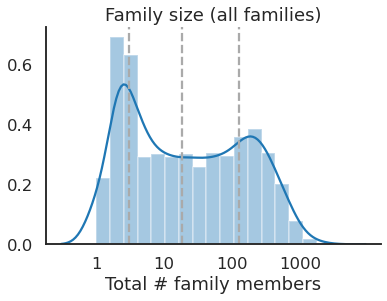

In [68]:
q_x = scipy.stats.mstats.mquantiles(family_sizes['log_size'], np.linspace(.25, 1, 4))
log_x = range(4)
exp_x = [10**x for x in log_x]

ax = sns.distplot(family_sizes['log_size'])
ax.set(xlabel='Total # family members', xticks = log_x, xticklabels = exp_x, 
       title = 'Family size (all families)')
sns.despine()

for q in q_x[:3]:
    plt.axvline(q, color='#aaaaaa', linestyle='--')

Family subsample:

In [65]:
family_sample = family_sizes.copy()
family_sample = family_sample[family_sample['size_q'] > 0]
family_sample = family_sample.groupby('size_q').sample(frac=.0305)
family_sample = family_sample.reset_index(drop=True)
print(family_sample.shape)
family_sample.head()

(90, 5)


,family,size,log_size,size_q,q_label
0,time-1587071865_eve-2898532_name-AN,9,0.954243,1,"(0.477, 1.255]"
1,time-1587676375_eve-2928342_name-NOOD,10,1.000000,1,"(0.477, 1.255]"
2,time-1574388279_eve-2312096_name-EPSTEIN,5,0.698970,1,"(0.477, 1.255]"
3,time-1580241953_eve-2636092_name-SHITTU,9,0.954243,1,"(0.477, 1.255]"
4,time-1578573856_eve-2547224_name-KIM,5,0.698970,1,"(0.477, 1.255]"


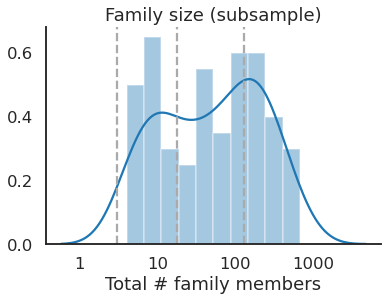

In [74]:
ax = sns.distplot(family_sample['log_size'],bins=10)
ax.set(xlabel='Total # family members', xticks = log_x, xticklabels = exp_x, 
       title = 'Family size (subsample)')
for q in q_x[:3]:
    plt.axvline(q, color='#aaaaaa', linestyle='--')
sns.despine()

Get repertoire, expertise measures for subsample:

In [80]:
sample_families = family_sample['family'].values
sample_viability = life_viability[life_viability['family'].isin(sample_families)]

n_families = len(sample_families)
n_players = len(np.unique(sample_viability['player']))
n_avatars = len(np.unique(sample_viability['avatar']))


print(sample_viability.shape)
print('N =\t%i families' % n_families)
print('\t%i players' % n_players)
print('\t%i avatars' % n_avatars)

(10734, 15)
N =	90 families
	4053 players
	10734 avatars


## Cumulative repertoire size

Load discoveries dataframe:

In [81]:
discoveries_df = pd.read_csv('../3_technology/outputs/family_discoveries.tsv', sep='\t')
discoveries_df['t_epoch'] = discoveries_df['t_epoch'].astype(np.int)
discoveries_df.head()

,seed,family,object_id,t_epoch,count
0,1573895673,time-1573895755_eve-2276905_name-ZABICKI,236,1573895799,1
1,1573895673,time-1573895755_eve-2276905_name-ZABICKI,134,1573895801,2
2,1573895673,time-1573895755_eve-2276905_name-ZABICKI,2873,1573895844,3
3,1573895673,time-1573895755_eve-2276905_name-ZABICKI,2742,1573895847,4
4,1573895673,time-1573895755_eve-2276905_name-ZABICKI,2861,1573895849,5


Get repertoire size by the time of each player's birth

In [ ]:
repertoire_list = []
for idx,row in notebook.tqdm(sample_viability.iterrows(), total=sample_viability.shape[0]):
    fam_discoveries = discoveries_df[discoveries_df['family'] == row['family']].copy()

    discovered = fam_discoveries[fam_discoveries['t_epoch'] < row['tBirth']]
    n_discoveries = discovered.shape[0]

    repertoire_list.append((row['avatar'], n_discoveries))

In [87]:
repertoire_df = pd.DataFrame(repertoire_list, columns=['avatar', 'repertoire_size'])
repertoire_df.head()

,avatar,repertoire_size
0,2283257,0
1,2283258,1
2,2283282,8
3,2283315,57
4,2283345,73


In [88]:
sample_repertoire = pd.merge(sample_viability, repertoire_df, on='avatar')
sample_repertoire.head()

,player,avatar,parent,family,tBirth,tDeath,age,cause_of_death,n_life,gametime,parent_life,parent_gametime,adult,adult_count,adult_sum,repertoire_size
0,7ef3243c6edae7f1b2ae2e3f215f4e0d41fc9109,2283257,-1,time-1574019178_eve-2283257_name-GREY,1574019178,1.574022e+09,60.00,oldAge,682,29575.77,NaN,NaN,1,0,0,0
1,0e4d213c7653d0cca240f0b650958292dbabe7dd,2283258,2283257,time-1574019178_eve-2283257_name-GREY,1574019200,1.574020e+09,11.03,hunger,4,18.45,682.0,29575.77,0,1,1,1
2,eb29a953ae53a0148a3f27c43b74002242739bda,2283282,2283257,time-1574019178_eve-2283257_name-GREY,1574019381,1.574022e+09,43.98,hunger,733,15670.62,682.0,29575.77,1,2,1,8
3,280b6cb02b9d029bc3c20c21af0abecf27ded956,2283315,2283257,time-1574019178_eve-2283257_name-GREY,1574019806,1.574020e+09,7.01,hunger,3,52.63,682.0,29575.77,0,3,2,57
4,f33b53269620f77f0e8edc2bdedfb0539efadafe,2283345,2283257,time-1574019178_eve-2283257_name-GREY,1574020116,1.574021e+09,17.50,hunger,19,698.60,682.0,29575.77,1,4,2,73


In [108]:
sample_repertoire.to_csv('outputs/survival_regression_inputs.tsv', sep='\t', index=False)

In [109]:
load_test = pd.read_csv('outputs/survival_regression_inputs.tsv', sep='\t')
load_test.head()

,player,avatar,parent,family,tBirth,tDeath,age,cause_of_death,n_life,gametime,parent_life,parent_gametime,adult,adult_count,adult_sum,repertoire_size
0,7ef3243c6edae7f1b2ae2e3f215f4e0d41fc9109,2283257,-1,time-1574019178_eve-2283257_name-GREY,1574019178,1.574022e+09,60.00,oldAge,682,29575.77,NaN,NaN,1,0,0,0
1,0e4d213c7653d0cca240f0b650958292dbabe7dd,2283258,2283257,time-1574019178_eve-2283257_name-GREY,1574019200,1.574020e+09,11.03,hunger,4,18.45,682.0,29575.77,0,1,1,1
2,eb29a953ae53a0148a3f27c43b74002242739bda,2283282,2283257,time-1574019178_eve-2283257_name-GREY,1574019381,1.574022e+09,43.98,hunger,733,15670.62,682.0,29575.77,1,2,1,8
3,280b6cb02b9d029bc3c20c21af0abecf27ded956,2283315,2283257,time-1574019178_eve-2283257_name-GREY,1574019806,1.574020e+09,7.01,hunger,3,52.63,682.0,29575.77,0,3,2,57
4,f33b53269620f77f0e8edc2bdedfb0539efadafe,2283345,2283257,time-1574019178_eve-2283257_name-GREY,1574020116,1.574021e+09,17.50,hunger,19,698.60,682.0,29575.77,1,4,2,73


8228 (76.65%) reached adulthood
3886 (36.20%) died of old age


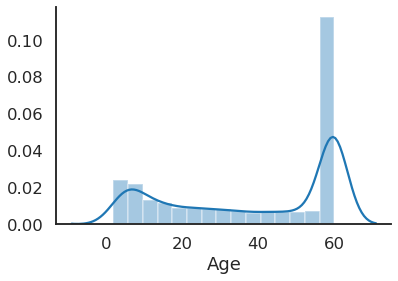

In [92]:
sample_n = sample_repertoire.shape[0]
sample_adults = np.sum(sample_repertoire['age'] >= 14)
sample_olds = np.sum(sample_repertoire['age'] == 60)

print('%i (%0.2f%%) reached adulthood' % (sample_adults, sample_adults/sample_n*100))
print('%i (%0.2f%%) died of old age' % (sample_olds, sample_olds/sample_n*100))

ax = sns.distplot(sample_repertoire['age'])
ax.set(xlabel = 'Age')
sns.despine()

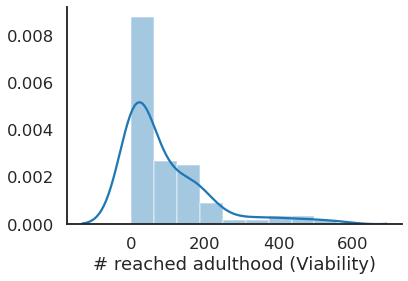

In [123]:
viability_sum = sample_repertoire.copy()
viability_sum['is_adult'] = sample_repertoire['age'] >= 14
viability_sum = viability_sum.groupby('family')['is_adult'].agg('sum').reset_index()
ax = sns.distplot(viability_sum['is_adult'])
ax.set(xlabel = '# reached adulthood (Viability)')
sns.despine()

['time-1595792875_eve-3205725_name-DONER'
 'time-1576425390_eve-2416469_name-GRAY'
 'time-1585367539_eve-2829693_name-KASTLER'
 'time-1574254663_eve-2300037_name-TIMES'
 'time-1588773850_eve-2971294_name-RUNNING'
 'time-1594550399_eve-3167000_name-BUTTS'
 'time-1591813536_eve-3064508_name-BADA'
 'time-1588969901_eve-2978511_name-BIRD'
 'time-1574574017_eve-2324595_name-WILLOW'
 'time-1591269225_eve-3048109_name-SNOW']


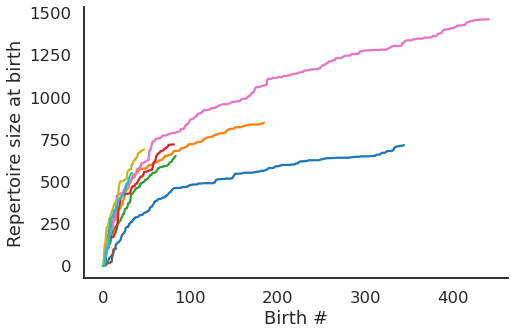

In [107]:
subsubsample = np.random.choice(sample_families, 10)
print(subsubsample)
d_subsub = sample_repertoire[sample_repertoire['family'].isin(subsubsample)]
ax = sns.relplot(data=d_subsub,x='adult_count', y='repertoire_size', hue='family', kind='line',
            legend=False, aspect=1.5)
ax.set(xlabel = 'Birth #', ylabel = 'Repertoire size at birth')

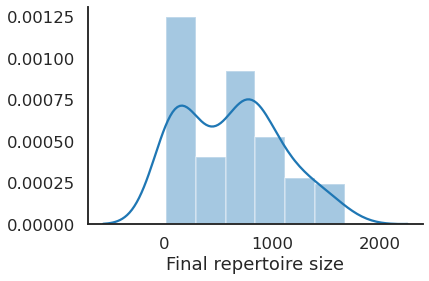

In [120]:
rep_sum = sample_repertoire.groupby('family')['repertoire_size'].agg('max').reset_index()
ax = sns.distplot(rep_sum['repertoire_size'])
ax.set(xlabel = 'Final repertoire size')
sns.despine()

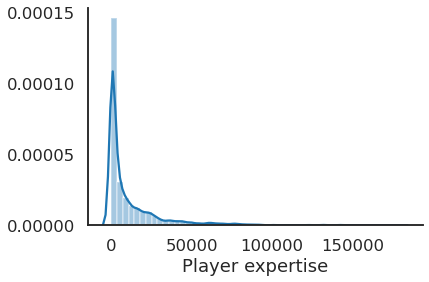

In [124]:
ax = sns.distplot(sample_repertoire['gametime'])
ax.set(xlabel = 'Player expertise')
sns.despine()

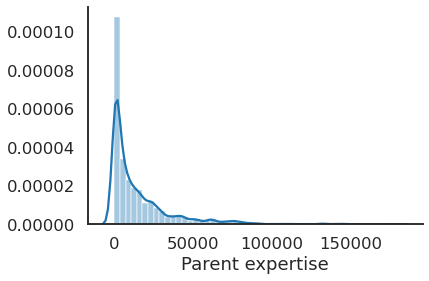

In [125]:
ax = sns.distplot(sample_repertoire['parent_gametime'])
ax.set(xlabel = 'Parent expertise')
sns.despine()

## Pick a subset to plot

In [ ]:
top_families = life_viability.groupby('family')['adult_count', 'adult_sum'].agg('max').reset_index()
top_families = top_families.sort_values(by='adult_sum', ascending=False)
top_families = top_families.reset_index(drop=True)
top_fam = top_families.iloc[0,0]
print('Winner: %s' % top_fam)
top_families

Get all members of top-performing family:

In [ ]:
top_lives = life_viability[life_viability['family'] == top_fam]
top_lives['reached_adulthood'] = top_lives['age'] >= 14
top_lives['died_old'] = top_lives['age'] == 60
top_lives['inexperienced'] = top_lives['gametime'] < np.median(top_lives['gametime'])

n_players = len(np.unique(top_lives['player']))
n_avatars = top_lives.shape[0]
n_adult = np.sum(top_lives['reached_adulthood'])
n_old = np.sum(top_lives['died_old'])

print('%i players' % n_players)
print('%i avatars' % n_avatars)
print('%i reached adulthood (%0.1f%%)' % (n_adult, n_adult/n_avatars*100))
print('%i died of old age' % n_old)
top_lives.head()

In [ ]:
def open_graph(f):
    with open(f) as handle:
        graph_data = json.load(handle)
    return nx.json_graph.node_link_graph(graph_data)

fam_template = '../2_demographics/outputs/families/families_%s.json'
fam_file = fam_template % top_fam
fam_graph = open_graph(fam_file)

nx.nx_agraph.write_dot(fam_graph,'fam.dot')
pos=graphviz_layout(fam_graph, prog='dot')
pos_coords = pd.DataFrame(list(pos.values()), columns=['x','y']).agg(['max', 'min'])
w = (pos_coords.loc['max', 'x'] - pos_coords.loc['min', 'x'])/150
h = (pos_coords.loc['max', 'y'] - pos_coords.loc['min', 'y'])/150

# Draw plot
plt.subplots(figsize=(w,h))
nx.draw(fam_graph, pos, with_labels=False, arrows=True)

In [ ]:
ax = sns.regplot(data=top_lives, x='gametime', y='reached_adulthood', logistic=True, ci=None,
                 scatter_kws={'alpha': 0.1})
ax.set(xlabel = 'Expertise', ylabel = 'Reached adulthood?', yticks = [0, 1], yticklabels = ['F', 'T'])

In [ ]:
ax = sns.regplot(data=top_lives, x='gametime', y='died_old', logistic=True, ci=None,
           scatter_kws={'alpha': 0.1})
ax.set(xlabel = 'Expertise', ylabel = 'Died of old age?', yticks = [0, 1], yticklabels = ['F', 'T'])

In [ ]:
ax = sns.regplot(data=top_lives, x='parent_gametime', y='reached_adulthood', logistic=True, ci=None,
           scatter_kws={'alpha': 0.1})
ax.set(xlabel = 'Parent expertise', ylabel = 'Reached adulthood?', yticks = [0, 1], yticklabels = ['F', 'T'])

In [ ]:
ax = sns.regplot(data=top_lives, x='parent_gametime', y='reached_adulthood', logistic=True, ci=None,
           scatter_kws={'alpha': 0.1})
ax.set(xlabel = 'Parent expertise', ylabel = 'Died of old age?', yticks = [0, 1], yticklabels = ['F', 'T'])

In [ ]:
ax = sns.regplot(data=top_lives, x='adult_sum', y='reached_adulthood', logistic=True, ci=None,
           scatter_kws={'alpha': 0.1})
ax.set(xlabel = 'Cumulative viability', ylabel = 'Reached adulthood?', yticks = [0, 1], yticklabels = ['F', 'T'])

In [ ]:
ax = sns.regplot(data=top_lives, x='adult_sum', y='died_old', logistic=True, ci=None,
           scatter_kws={'alpha': 0.1})
ax.set(xlabel = 'Cumulative viability', ylabel = 'Died of old age?', yticks = [0, 1], yticklabels = ['F', 'T'])

## Cumulative repertoire size

In [ ]:
discoveries = pd.read_csv('../3_technology/outputs/')

## Save to file

In [ ]:
life_viability.to_csv('outputs/survival_inputs.tsv', sep='\t', index=False)